In [98]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from scipy.optimize import minimize
import scipy.constants as const

In [99]:
#cuts off a distance array such that it only has elements < a certain length

def dist_cutoff(dist, dist_lim):
    distance = []
    for x in dist:
        if (x < dist_lim):
            distance.append(x)
    return np.asarray(distance)

In [100]:
#cuts off a density array at a given number of elements
#not in place

def dens_cutoff(dens, n_elements):
    densities = np.zeros(n_elements)
    for i in range(0, n_elements):
        densities[i] = dens[i]
    return densities

In [107]:
#functions
def i1(arg):
    return np.tanh(arg/5)

def i2(arg):
    return np.tanh(arg) 

def i3(arg):
    return (np.tanh(np.sqrt(arg)))**2

def beta(f15, rho):
    f = f15 * 1e15
    hbar = const.hbar
    c = const.c
    G = const.G
    GeV_to_J = 1.60218e-10
    prefactor = 1.6e-12 * (rho ** (1/2))
    factor = (hbar * (c**5)) / (32 * np.pi * G * f**2) 
    return prefactor*factor / ((GeV_to_J)**2)

0.03315404258195512


In [73]:
#analytic profile of the core

def philip_fun(rc, rho, i1term, exp_inner, exp_outer, central_den, r):
    b = beta(f, central_den)
    rho = (1.9e7 / (rc**4))
    #i1term = 1. + 2.6*i1(b)
    #exp_inner = 2. - ((1./5.) * i2(b))
    #exp_outer = -8. + ((22./5.)*i3(b))
    term = (1 + i1term * (r/rc)**exp_inner)**exp_outer
    return 10**rho * term

In [74]:
#X2 function for simple fit

def X2_fun_philip(x, dist, dens, dist_lim):
    rc = x[0]
    rho = x[1] 
    i1term = x[2]
    exp_inner = x[3]
    exp_outer = x[4]
    r = dist_cutoff(dist, dist_lim)
    densities = dens_cutoff(dens, len(r))
    X2 = (((philip_fun(rc, rho, i1term, exp_inner, exp_outer, r)) - densities)**2)
    return X2[0:len(X2)].sum()

In [97]:
#radial-density fitting function
#params are two nparrays
#analytic radial profile function

def fit_profile_philip(dist, dens, dist_lim):
    dist1 = np.sort(dist)
    dens1 = (-1)*(np.sort(dens*(-1)))
    params = (dist1, dens1, dist_lim)
    p = (0.17, 8, 3.6, 2, -8)
    x0 = np.asarray(p)
    result = minimize(X2_fun_philip, x0, args = params, bounds = [(-3, 3), (5, 12), (0, 10), (0, 5), (-10, 5)])
    return result

In [22]:
# In simple fit case, computing rc as a function of f
f_vals = [np.Inf, 4, 2, 1.75, 1.5, 1.25, 1.1875, 1.1562, 1.1484]
f = np.asarray(f_vals)
rc_vals = np.zeros(len(f_vals))
rho_vals = np.zeros(len(f_vals))
i1term_vals = np.zeros(len(f_vals))
exp_inner_vals = np.zeros(len(f_vals))
exp_outer_vals = np.zeros(len(f_vals))
X2_vals = np.zeros(len(f_vals))


pathInf = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256/rad_filesradial0400.h5'
path4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256/radial0400.h5'
path2 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
path175 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.75L20T4n40r256/radial0040.h5'
path15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256/radial0400.h5'
path125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.25L20T4n40r256/radial0040.h5'
path11875 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r256/radial0040.h5'
path11562 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1562L20T4n40r256/radial0040.h5'
path11484 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1484L20T4n40r256/radial0040.h5'

paths = [pathInf, path4, path2, path175, path15, path125, path11875, path11562, path11484]
for i in range(0, len(paths)):
    f_val = f_vals[i]
    hf = h5py.File(paths[i], 'r')
    dist = np.array(hf['distances'])
    dens = np.array(hf['densities'])
    res = fit_profile_philip(dist, dens, 0.40)
    
    #params
    rc = np.abs(res.x[0])
    rho = res.x[1]
    i1term = res.x[2]
    exp_inner = res.x[3]
    exp_outer = res.x[4]
    X2_val = res.fun
    
    plt.scatter(dist, dens, s = 1)
    plt.plot(dist, philip_fun(rc, rho, i1term, exp_inner, exp_outer, dist), 'r')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel('Density (Msun / (kpc)^3)')
    plt.title('Radial Distance vs. Density, f = ' + str(f_val))
    plt.ylim(10**4, 10**(12.5))
    plt.xlim(10**(-2), 10**(1.4))
    plt.legend(['rc = ' + "%.2f" % rc + "\nrho = 10^" + "%.2f" % rho + "\ni1term = " + "%.2f" % i1term + "\nexp_inner = " + "%.2f" % exp_inner + "\nexp_outer = " + "%.2f" % exp_outer])
    plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/philip_fit_f' + str(f_val) + '.png', dpi = 200)
    plt.clf()
    
    # saving values to arrays
    rc_vals[i] = np.abs(rc)
    rho_vals[i] = rho
    i1term_vals[i] = i1term
    exp_inner_vals[i] = exp_inner
    exp_outer_vals[i] = exp_outer
    X2_vals[i] = X2_val

#rc plot
plt.scatter((f**-1), rc_vals)
plt.xlabel('1/f')
plt.ylabel('rc')
plt.title('f^-1 vs. rc (philip_fun)')
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/rc_scaling.png', dpi = 200)
plt.clf()

#rc plot
plt.scatter((f**-1), rc_vals)
plt.xlabel('1/f')
plt.ylabel('rc')
plt.title('f^-1 vs. rc (philip_fun)')
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/rc_scaling.png', dpi = 200)
plt.clf()

#rc plot
plt.scatter((f**-1), exp_outer_vals)
plt.xlabel('1/f')
plt.ylabel('exp_outer')
plt.title('f^-1 vs. exp_outer (philip_fun)')
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/exp_outer_scaling.png', dpi = 200)
plt.clf()

#rho plot
plt.scatter((f**-1), rho_vals)
plt.xlabel('1/f')
plt.ylabel('rho')
plt.title('f^-1 vs. rho (philip_fun)')
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/rho_scaling.png', dpi = 200)
plt.clf()

#rc plot
plt.scatter((f**-1), i1term_vals)
plt.xlabel('1/f')
plt.ylabel('i1term')
plt.title('f^-1 vs. i1term (philip_fun)')
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/i1term_scaling.png', dpi = 200)
plt.clf()

#rc plot
plt.scatter((f**-1), exp_inner_vals)
plt.xlabel('1/f')
plt.ylabel('exp_inner')
plt.title('f^-1 vs. exp_inner (philip_fun)')
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/exp_inner_scaling.png', dpi = 200)
plt.clf()

#rc plot
plt.scatter((f**-1), X2_vals)
plt.xlabel('1/f')
plt.ylabel('X2')
plt.title('f^-1 vs. X2 (philip_fun)')
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/X2_scaling.png', dpi = 200)
plt.clf()

params = h5py.File('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/philip_params.h5', 'w')
params.create_dataset('f', data=f_vals)
params.create_dataset('rc', data=rc_vals)
params.create_dataset('rho', data=rho_vals)
params.create_dataset('i1term', data=i1term_vals)
params.create_dataset('exp_outer', data=exp_inner_vals)
params.create_dataset('exp_inner', data=exp_outer_vals)
params.create_dataset('X2', data=X2_vals)
params.close()

<Figure size 432x288 with 0 Axes>

      fun: 2392517558976718.0
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.091700e+12, -3.329155e+13,  3.362650e+12, -1.839320e+13,
       -1.371400e+12])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 612
      nit: 74
   status: 0
  success: True
        x: array([ 0.99996311, 10.26106443,  2.97722399,  1.99391789, -7.35763061])


(0.01, 25.118864315095795)

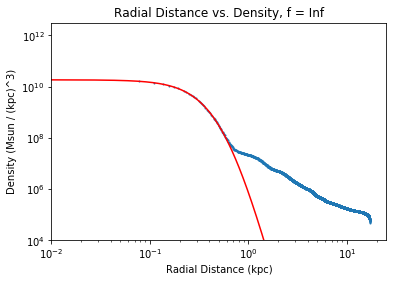

In [96]:
path125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256/rad_filesradial0400.h5'
hf125 = h5py.File(path125, 'r')
dist125 = np.array(hf125['distances'])
dens125 = np.array(hf125['densities'])
res = fit_profile_philip(dist125, dens125, 0.65)
rc125 = np.abs(res.x[0])
rho125 = res.x[1]
i1term125 = res.x[2]
exp_inner125 = res.x[3]
exp_outer125 = res.x[4]
print(res)
plt.scatter(dist125, dens125, s = 1)
test_dist = np.linspace(0.01, 15, 100000)
plt.plot(test_dist, philip_fun(rc125, rho125, i1term125, exp_inner125, exp_outer125, test_dist), 'r')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density, f = Inf')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))

#plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/simple_function/)

Fitting the parameters as functions of beta:

In [76]:
# Let's try to compute rc as a function of f:
# Trying to fit a Gaussian
def Gauss(r, rc, rho, a):
    return rho * np.exp(-1*((r)/rc)**a)

#X2 function for Gauss
def X2_fun_Gauss(x, dist, dens):
    #args[0] = f 
    #args[1] = dist 
    #args[2] = dens 
    #args[3] = dist_lim
    rc = x[0]
    rho = x[1] 
    a = x[2]
    #r = dist_cutoff(dist, dist_lim)
    #densities = dens_cutoff(dens, len(r))
    X2 = (((Gauss(dist, rc, rho, a)) - (dens))**2)
    return X2[0:(len(X2))].sum()

#fitting function
def fit_profile_Gauss(dist, dens):
    #dist1 = np.sort(dist)
    #dens1 = (-1)*(np.sort(dens*(-1)))
    params = (dist, dens)
    p = (0.2, 1, 1.5)
    x0 = np.asarray(p)
    result = minimize(X2_fun_Gauss, x0, args = params, bounds = [(0.0001, 1), (0, 3), (0.5, 100)])
    return result

      fun: 0.04735487670729856
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.90115154e-06, -2.72296075e-05, -6.93889390e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 132
      nit: 29
   status: 0
  success: True
        x: array([ 0.90256587,  0.95894616, 20.66169061])
[0.0406723  0.03047992 0.04105508 0.11890385 0.03349717 0.06307168
 0.0303315  0.10951916 0.10456302]


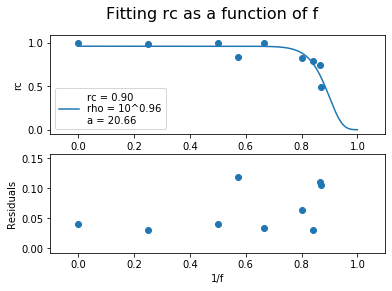

In [77]:
philip = h5py.File('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/philip_params.h5', 'r')
f_inv = 1/np.array(philip['f'])
rc = np.array(philip['rc'])
res = fit_profile_Gauss(f_inv, rc)
print(res)

rc_val = res.x[0]
rho = res.x[1]
a = res.x[2]

x_axis = np.linspace(0, 1, 1000)
y_axis = Gauss(x_axis, rc_val, rho, a)

fig, axs = plt.subplots(2, 1)
axs[0].plot(x_axis, y_axis, label= 'rc = ' + "%.2f" % rc_val + "\nrho = 10^" + "%.2f" % rho + "\na = " + "%.2f" % a)
axs[0].scatter(f_inv, rc)
axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylabel('rc')
axs[0].legend(loc="lower left")

residuals = np.abs(rc - Gauss(f_inv, rc_val, rho, a))
print(residuals)
axs[1].scatter(f_inv, residuals)
axs[1].set_xlim(-0.1, 1.1)
axs[1].set_ylabel('Residuals')

plt.xlabel('1/f')

fig.suptitle('Fitting rc as a function of f', fontsize=16)
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/fitting_rc.png', dpi = 150)

In [78]:
def rc(f):
    philip = h5py.File('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/philip_params.h5', 'r')
    f_inv = 1/np.array(philip['f'])
    rc = np.array(philip['rc'])
    res = fit_profile_Gauss(f_inv, rc)
    return Gauss(1/f, res.x[0], res.x[1], res.x[2])

In [86]:
# First, we try to compute beta as a function of f:

def beta(f):
    core = rc(f)
    f = f * 1e15
    hbar = const.hbar
    c = const.c
    G = const.G
    GeV_to_J = 1.60218e-10
    prefactor = 6.9e-9 * (core ** (-2))
    factor = (hbar * (c**5)) / (32 * np.pi * G * f**2) 
    return prefactor*factor / ((GeV_to_J)**2)

In [87]:
def inner_prefact(f, a, b, c):
    return a + b*np.tanh(c* beta(f))

In [88]:
def X2_inner_prefact(x, beta, prefactor):
    a = x[0]
    b = x[1]
    c = x[2]
    X2 = (((inner_prefact(beta, a, b, c)) - (prefactor))**2)
    return X2[0:(len(X2))].sum()

In [89]:
def fit_profile_inner(f, inner):
    params = (f, inner)
    p = (0.091, 0.24, 1)
    x0 = np.asarray(p)
    result = minimize(X2_inner_prefact, x0, args = params, bounds = [(0.0001, 5), (0, 5), (0, 10)])
    return result

/home/mnotis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/mnotis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/home/mnotis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


      fun: 12.590521348797665
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.0658141e-06, 1.0658141e-06, 0.0000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 1
   status: 0
  success: True
        x: array([2.11622615, 2.20375565, 1.        ])
Poly fit =[-10.78847784  16.08192587  -3.4732974    2.99644717]


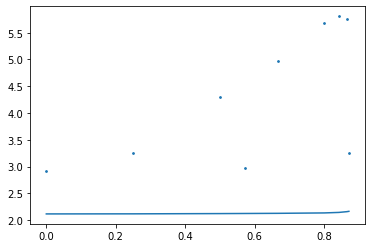

In [95]:
philip = h5py.File('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/philip_params.h5', 'r')
f_inv = 1/np.array(philip['f'])
i1term = np.array(philip['i1term'])
res = fit_profile_inner(f_inv, i1term)
print(res)

res_poly = np.polyfit(f_inv, i1term, 3)
print('Poly fit =' + str(res_poly))
a = res.x[0]
b = res.x[1]
c = res.x[2]
vals = inner_prefact(np.array(philip['f']), a, b, c)
plt.scatter(f_inv, i1term, s = 3)
plt.plot(f_inv, vals)